In [1]:
import yfinance as yf
import pandas as pd
import numpy as np


In [2]:
nifty50_tickers = [
    'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'HINDUNILVR.NS',
    'SBIN.NS', 'LT.NS', 'KOTAKBANK.NS', 'ITC.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS',
    'AXISBANK.NS', 'HCLTECH.NS', 'BAJFINANCE.NS', 'MARUTI.NS', 'SUNPHARMA.NS', 'WIPRO.NS',
    'ULTRACEMCO.NS', 'TITAN.NS', 'HINDALCO.NS', 'NTPC.NS', 'JSWSTEEL.NS', 'TECHM.NS',
    'POWERGRID.NS', 'TATAMOTORS.NS', 'GRASIM.NS', 'ADANIENT.NS', 'COALINDIA.NS',
    'ONGC.NS', 'NESTLEIND.NS', 'BPCL.NS', 'UPL.NS', 'EICHERMOT.NS', 'DRREDDY.NS',
    'DIVISLAB.NS', 'HEROMOTOCO.NS', 'BAJAJFINSV.NS', 'CIPLA.NS', 'HDFCLIFE.NS',
    'SHREECEM.NS', 'SBILIFE.NS', 'INDUSINDBK.NS', 'BRITANNIA.NS', 'BAJAJ-AUTO.NS',
    'TATACONSUM.NS', 'APOLLOHOSP.NS', 'M&M.NS'
]


In [3]:
data = yf.download(nifty50_tickers, start='2022-01-01', end='2024-09-01')['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  48 of 48 completed


In [4]:
data = data.ffill().bfill()  # Forward-fill then back-fill if there are any missing values... here we have cleaned the data


In [5]:
print(data.isnull().sum().sort_values(ascending=False))  # should be all 0 if clean
print(data.shape)
# displays the number of missing values in each column
# .shape return the number of rows and columns.


Ticker
ADANIENT.NS      0
APOLLOHOSP.NS    0
ASIANPAINT.NS    0
AXISBANK.NS      0
BAJAJ-AUTO.NS    0
BAJAJFINSV.NS    0
BAJFINANCE.NS    0
BHARTIARTL.NS    0
BPCL.NS          0
BRITANNIA.NS     0
CIPLA.NS         0
COALINDIA.NS     0
DIVISLAB.NS      0
DRREDDY.NS       0
EICHERMOT.NS     0
GRASIM.NS        0
HCLTECH.NS       0
HDFCBANK.NS      0
HDFCLIFE.NS      0
HEROMOTOCO.NS    0
HINDALCO.NS      0
HINDUNILVR.NS    0
ICICIBANK.NS     0
INDUSINDBK.NS    0
INFY.NS          0
ITC.NS           0
JSWSTEEL.NS      0
KOTAKBANK.NS     0
LT.NS            0
M&M.NS           0
MARUTI.NS        0
NESTLEIND.NS     0
NTPC.NS          0
ONGC.NS          0
POWERGRID.NS     0
RELIANCE.NS      0
SBILIFE.NS       0
SBIN.NS          0
SHREECEM.NS      0
SUNPHARMA.NS     0
TATACONSUM.NS    0
TATAMOTORS.NS    0
TCS.NS           0
TECHM.NS         0
TITAN.NS         0
ULTRACEMCO.NS    0
UPL.NS           0
WIPRO.NS         0
dtype: int64
(656, 48)


In [6]:
returns = data.pct_change().dropna()
# Stores the cleaned percentage changes in a new DataFrame called returns.


In [7]:
rolling_vol = returns.rolling(window=20).std()
# Calculates the standard deviation of returns within each 20-day window.
# and then stores it in a new dataframe rolling_vol

In [8]:
rolling_vol = rolling_vol.dropna()
# since the first 19 rows will be empty so we drop them

In [9]:
vol_df = rolling_vol.copy()
# Creates a copy of rolling_vol and assigns it to vol_df.
vol_df.columns.name = 'Ticker'
# Assigns a name to the columns axis of the DataFrame.
vol_df.index.name = 'Date'
# Assigns a name to the index (rows), which is usually a DatetimeIndex


In [10]:
print("Rolling Volatility (first 5 rows):")
print(vol_df.head())


Rolling Volatility (first 5 rows):
Ticker      ADANIENT.NS  APOLLOHOSP.NS  ASIANPAINT.NS  AXISBANK.NS  \
Date                                                                 
2022-02-01     0.023519       0.023746       0.015770     0.020785   
2022-02-02     0.023841       0.025290       0.015450     0.021215   
2022-02-03     0.024147       0.025271       0.014520     0.020913   
2022-02-04     0.024141       0.025434       0.014913     0.020959   
2022-02-07     0.024317       0.026915       0.014369     0.021243   

Ticker      BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  BHARTIARTL.NS  \
Date                                                                     
2022-02-01       0.017132       0.024152       0.020968       0.016921   
2022-02-02       0.017152       0.026859       0.021992       0.016852   
2022-02-03       0.017340       0.024391       0.019598       0.016914   
2022-02-04       0.017531       0.024385       0.019488       0.016640   
2022-02-07       0.018460     

In [11]:
# Rolling Mean Forecast (5-day rolling mean of the 20-day rolling volatility)
vol_forecast_rm = rolling_vol.rolling(window=5).mean()

#we are applying another rolling window, this time of size 5 days.
# For each day, this looks at the most recent 5 days of volatility estimates.
# The result is stored in a new DataFrame called vol_forecast_rm


In [12]:
# EWMA Forecast (lambda = 0.94)
lambda_ = 0.9
# Higher λ (closer to 1) means more weight on past observations and slower reaction to new data.

vol_squared = returns ** 2
ewma_vol = vol_squared.ewm(alpha=1 - lambda_).mean() ** 0.5
# .ewm(alpha=1 - λ) applies an Exponentially Weighted Moving Average with decay controlled by α = 1 - λ = 0.06.


In [13]:
from statsmodels.tsa.ar_model import AutoReg # a tool for time series forecasting.

ar1_forecast = {}
# Initializes an empty dictionary to store the AR(1) forecasted volatility for each ticker.

for ticker in rolling_vol.columns:
# Loops through each ticker/asset in your volatility DataFrame (rolling_vol).
    series = rolling_vol[ticker].dropna()
    # Selects the rolling volatility series for a given ticker and drops NaN values.
    try:
        model = AutoReg(series, lags=1).fit()
        #Fits an AR(1) model to the time series:
        forecast = model.predict(start=len(series), end=len(series))
        # Forecasts the next value (i.e., next-period volatility).

        ar1_forecast[ticker] = forecast.values[0]
    except Exception as e:
        ar1_forecast[ticker] = np.nan


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po

In [14]:
# Get latest values from Rolling and EWMA methods
last_rolling = rolling_vol.iloc[-1]
# Gets the most recent (last) 20-day rolling volatility for all tickers
last_rm = vol_forecast_rm.iloc[-1]
# Gets the last available 5-day smoothed rolling mean of volatility.
last_ewma = ewma_vol.iloc[-1]
# Gets the most recent EWMA volatility estimate.
ar1_series = pd.Series(ar1_forecast)
# Converts your dictionary of AR(1) forecasts into a Pandas Series

# Combine into a single DataFrame
forecast_df = pd.DataFrame({
    'Rolling': last_rolling,
    'Rolling_Mean': last_rm,
    'EWMA': last_ewma,
    'AR1': ar1_series
})

# Drop any rows with missing forecasts
forecast_df = forecast_df.dropna()

# Preview the forecasts
print(forecast_df.head())


                Rolling  Rolling_Mean      EWMA       AR1
ADANIENT.NS    0.016302      0.016931  0.016245  0.016468
APOLLOHOSP.NS  0.012208      0.012272  0.012093  0.012267
ASIANPAINT.NS  0.010602      0.011427  0.010643  0.010650
AXISBANK.NS    0.009983      0.009926  0.011598  0.010111
BAJAJ-AUTO.NS  0.015124      0.015017  0.015188  0.015076


In [15]:
# Choose one method, say EWMA
selected_forecast = forecast_df['EWMA']

# Normalize using Min-Max scaling
normalized_vol = (selected_forecast - selected_forecast.min()) / (selected_forecast.max() - selected_forecast.min())

# Store in a DataFrame
normalized_df = pd.DataFrame({
    'Forecasted_Volatility': selected_forecast,
    'Normalized_Volatility': normalized_vol
})

print(normalized_df.head())


               Forecasted_Volatility  Normalized_Volatility
ADANIENT.NS                 0.016245               0.499639
APOLLOHOSP.NS               0.012093               0.216581
ASIANPAINT.NS               0.010643               0.117731
AXISBANK.NS                 0.011598               0.182818
BAJAJ-AUTO.NS               0.015188               0.427636


In [16]:
# Example: Risk-averse investor
risk_score = 0.2  # (change this value based on user input)


In [17]:
# Compute distance from investor risk score
normalized_df['Distance'] = abs(normalized_df['Normalized_Volatility'] - risk_score)

# Sort by closest match
matched_stocks = normalized_df.sort_values(by='Distance').head(3)

print("Top 3 matched stocks based on investor profile:")
print(matched_stocks)


Top 3 matched stocks based on investor profile:
               Forecasted_Volatility  Normalized_Volatility  Distance
APOLLOHOSP.NS               0.012093               0.216581  0.016581
AXISBANK.NS                 0.011598               0.182818  0.017182
DRREDDY.NS                  0.011577               0.181396  0.018604


In [18]:
selected_tickers = matched_stocks.index.tolist()
print("Selected Tickers:", selected_tickers)


Selected Tickers: ['APOLLOHOSP.NS', 'AXISBANK.NS', 'DRREDDY.NS']


In [19]:
inv_vol = 1 / matched_stocks['Forecasted_Volatility']
inv_weights = inv_vol / inv_vol.sum()
weights_inverse_vol = inv_weights.to_dict()
print("Inverse Volatility Weights:", weights_inverse_vol)


Inverse Volatility Weights: {'APOLLOHOSP.NS': 0.323911015436531, 'AXISBANK.NS': 0.3377403470688797, 'DRREDDY.NS': 0.33834863749458927}


In [20]:
initial_investment = 10_00_000  # ₹10 Lakhs

# Define equal weights based on the selected tickers
# 'selected_tickers' variable was defined in a previous cell
num_selected_stocks = len(selected_tickers)
if num_selected_stocks > 0:
    equal_weight = 1 / num_selected_stocks
    weights_equal = {ticker: equal_weight for ticker in selected_tickers}
else:
    weights_equal = {} # Handle the case where no tickers were selected

# Choose weight strategy
# Uncomment the line you want to use
weights = weights_equal         # Use equal weights
# weights = weights_inverse_vol # Or use inverse volatility weights

# Allocate capital per stock
capital_allocations = {ticker: weight * initial_investment for ticker, weight in weights.items()}
print("Capital Allocation:")
print(capital_allocations)

Capital Allocation:
{'APOLLOHOSP.NS': 333333.3333333333, 'AXISBANK.NS': 333333.3333333333, 'DRREDDY.NS': 333333.3333333333}


In [21]:
# You may already have this data, but in case:
backtest_data = yf.download(selected_tickers, start='2022-01-01', end='2025-01-01')['Close']
backtest_data = backtest_data.ffill().bfill()  # Fill missing values

print("Backtest Price Data (Head):")
print(backtest_data.head())


[*********************100%***********************]  3 of 3 completed

Backtest Price Data (Head):
Ticker      APOLLOHOSP.NS  AXISBANK.NS  DRREDDY.NS
Date                                              
2022-01-03    4932.958008   693.329041  956.541077
2022-01-04    4907.356445   706.073608  953.052429
2022-01-05    4915.905762   723.746582  944.173218
2022-01-06    4907.208008   727.131775  934.131104
2022-01-07    4963.946289   727.430420  928.011292


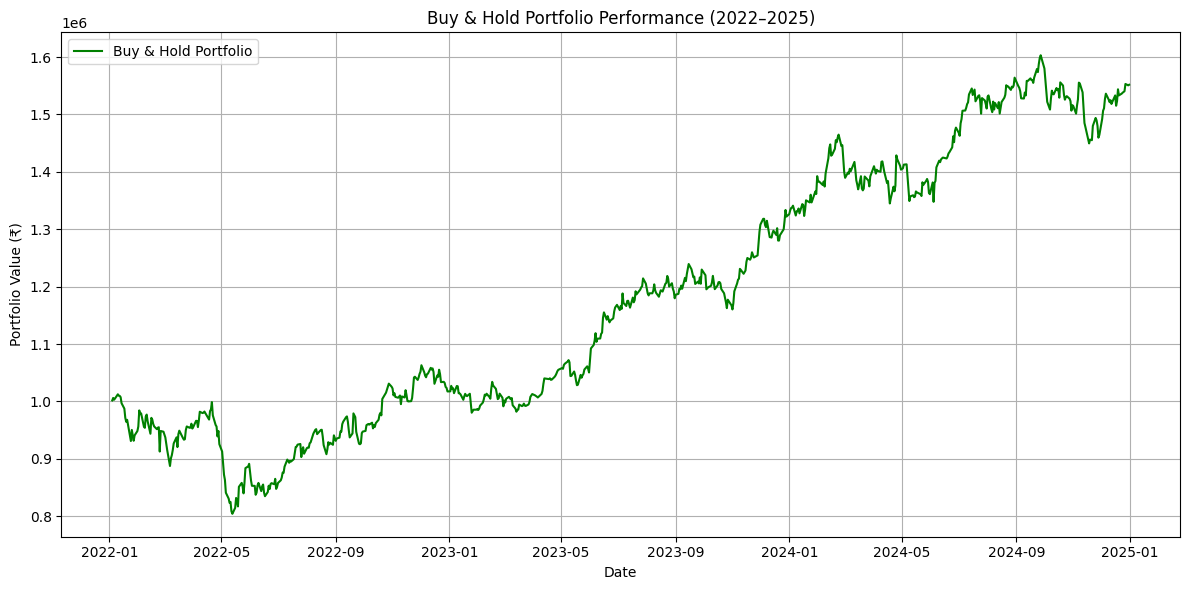

📈 Final Portfolio Value: ₹1,551,722.76
✅ Total Return: 55.17%
📅 Annualized Return: 16.33%
⚠️ Annualized Volatility: 16.26%
📊 Sharpe Ratio: 1.00


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Selected tickers
selected_tickers = ['APOLLOHOSP.NS', 'AXISBANK.NS', 'DRREDDY.NS']

# Weights based on inverse volatility (already computed earlier)
weights_inverse_vol = {
    'APOLLOHOSP.NS': 0.376714,
    'AXISBANK.NS': 0.276143,
    'DRREDDY.NS': 0.347143
}
weights = weights_inverse_vol  # You can switch to equal if needed

# Capital allocation
initial_investment = 10_00_000  # ₹10 Lakhs
capital_allocations = {ticker: weight * initial_investment for ticker, weight in weights.items()}

# Backtest price data (already downloaded)
# Use 'backtest_data' that you already downloaded earlier
# backtest_data = yf.download(selected_tickers, start='2022-01-01', end='2025-01-01')['Close']
# backtest_data = backtest_data.ffill().bfill()

# Compute daily returns
daily_returns = backtest_data.pct_change().dropna()

# Portfolio returns using weights
portfolio_returns = daily_returns.dot(np.array([weights[t] for t in selected_tickers]))

# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Scale to initial investment
portfolio_value = cumulative_returns * initial_investment

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Buy & Hold Portfolio', color='green')
plt.title('Buy & Hold Portfolio Performance (2022–2025)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Portfolio metrics
final_value = portfolio_value.iloc[-1]
total_return = (final_value - initial_investment) / initial_investment
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

# Print results
print(f"📈 Final Portfolio Value: ₹{final_value:,.2f}")
print(f"✅ Total Return: {total_return:.2%}")
print(f"📅 Annualized Return: {annualized_return:.2%}")
print(f"⚠️ Annualized Volatility: {annualized_volatility:.2%}")
print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")


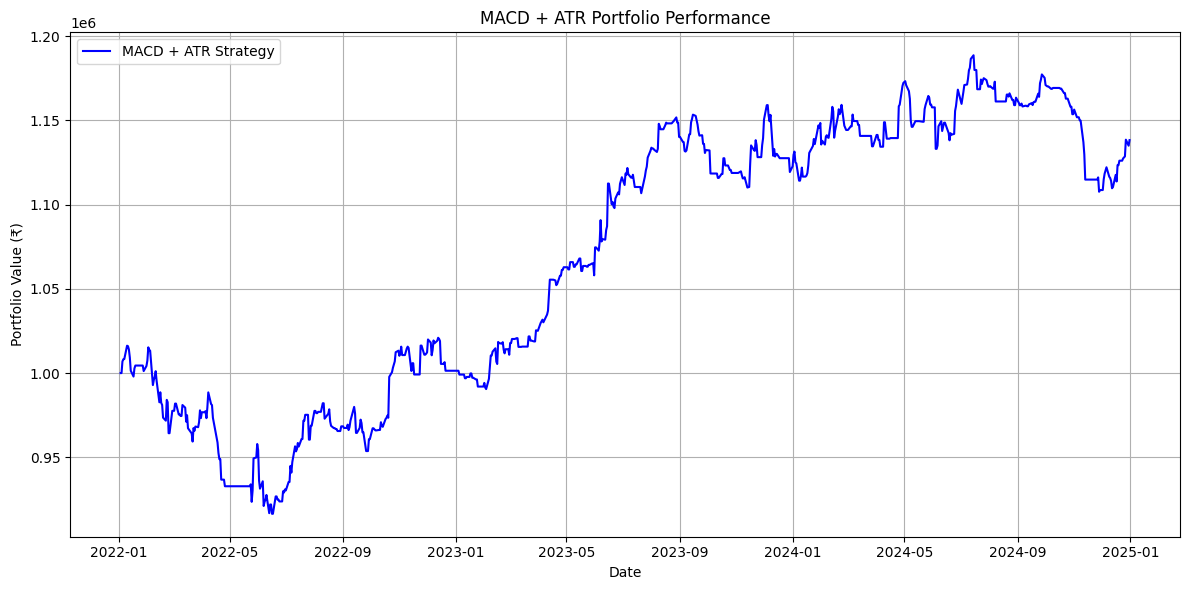

📈 Final Value: ₹1,138,243.43
✅ Total Return: 13.82%
📅 Annualized Return: 4.70%
⚠️ Annualized Volatility: 7.59%
📊 Sharpe Ratio: 0.62


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_macd_atr_strategy(price_df, ticker, k=2):
    df = price_df[[ticker]].dropna().copy()
    df.rename(columns={ticker: 'Close'}, inplace=True)

    # MACD Calculation
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # ATR Calculation (14-day)
    # The High and Low are assumed to be the Close price in this simplified example.
    # In a real-world scenario, you would need actual High and Low prices.
    df['High'] = df['Close']
    df['Low'] = df['Close']
    df['PrevClose'] = df['Close'].shift(1)

    # Corrected calculation for True Range
    df['TR'] = df[['High', 'Low']].max(axis=1) - df[['Low', 'PrevClose']].min(axis=1)

    df['ATR'] = df['TR'].rolling(window=14).mean()

    # Signals
    df['Position'] = 0
    # Enter position when MACD crosses above Signal
    df.loc[df['MACD'] > df['Signal'], 'Position'] = 1
    # Exit position when MACD crosses below Signal (this might be too simplistic for an exit)
    df.loc[df['MACD'] < df['Signal'], 'Position'] = 0
    df['Position'] = df['Position'].ffill() # Forward fill to maintain position until explicitly exited

    # Trailing Stop-loss
    # Track the highest close price reached while in a long position
    df['Peak'] = df['Close'].where(df['Position'] == 1).cummax()
    # Calculate the stop-loss level
    df['StopLoss'] = df['Peak'] - k * df['ATR']
    # Identify exit signals based on price falling below stop-loss while in a long position
    df['Exit'] = (df['Close'] < df['StopLoss']) & (df['Position'] == 1)

    # Apply stop-loss exits iteratively
    in_trade = False
    # Iterate through the DataFrame to apply the stop-loss logic
    for i in range(1, len(df)):
        # If currently in a trade
        if in_trade:
            # Check if the stop-loss exit condition is met for the current row
            if df.iloc[i]['Exit']:
                # If exit condition is met, set the position for the current row to 0
                df.iat[i, df.columns.get_loc('Position')] = 0
                # Set in_trade flag to False as the position is exited
                in_trade = False
        # If not currently in a trade
        else:
            # Check if a new long position is initiated in the current row
            if df.iloc[i]['Position'] == 1 and df.iloc[i - 1]['Position'] == 0:
                # If a new position is initiated, set in_trade flag to True
                in_trade = True

    # Calculate strategy returns based on the position held on the previous day
    df['Strategy_Return'] = df['Position'].shift(1) * df['Close'].pct_change()
    # Calculate cumulative returns of the strategy
    df['Cumulative'] = (1 + df['Strategy_Return']).cumprod()

    return df[['Close', 'MACD', 'Signal', 'Position', 'Strategy_Return', 'Cumulative']]

# Run strategy for each selected stock
results = {}
for ticker in selected_tickers:
    # Ensure backtest_data is available and correctly structured
    if ticker in backtest_data.columns:
        results[ticker] = compute_macd_atr_strategy(backtest_data, ticker)
    else:
        print(f"Warning: Data for {ticker} not found in backtest_data.")
        results[ticker] = pd.DataFrame() # Add an empty DataFrame to avoid errors

# Combine Portfolio Returns
# Filter out tickers for which no data was available or processing failed
valid_tickers = [t for t in selected_tickers if not results[t].empty]

if valid_tickers:
    # Sum the weighted returns for valid tickers
    combined_returns = sum(results[t]['Strategy_Return'].fillna(0) * weights[t] for t in valid_tickers)
    # Calculate the cumulative returns for the portfolio, scaled by initial investment
    combined_cum_returns = (1 + combined_returns).cumprod() * initial_investment

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined_cum_returns, label='MACD + ATR Strategy', color='blue')
    plt.title('MACD + ATR Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Metrics
    final_val = combined_cum_returns.iloc[-1]
    total_ret = (final_val - initial_investment) / initial_investment
    # Annualize returns assuming 252 trading days in a year
    ann_ret = combined_returns.mean() * 252
    # Annualize volatility
    ann_vol = combined_returns.std() * np.sqrt(252)
    # Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
    sharpe = ann_ret / ann_vol

    print(f"📈 Final Value: ₹{final_val:,.2f}")
    print(f"✅ Total Return: {total_ret:.2%}")
    print(f"📅 Annualized Return: {ann_ret:.2%}")
    print(f"⚠️ Annualized Volatility: {ann_vol:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f}")
else:
    print("No valid tickers processed for the MACD + ATR strategy.")

<ipython-input-28-2dde81da4182>:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


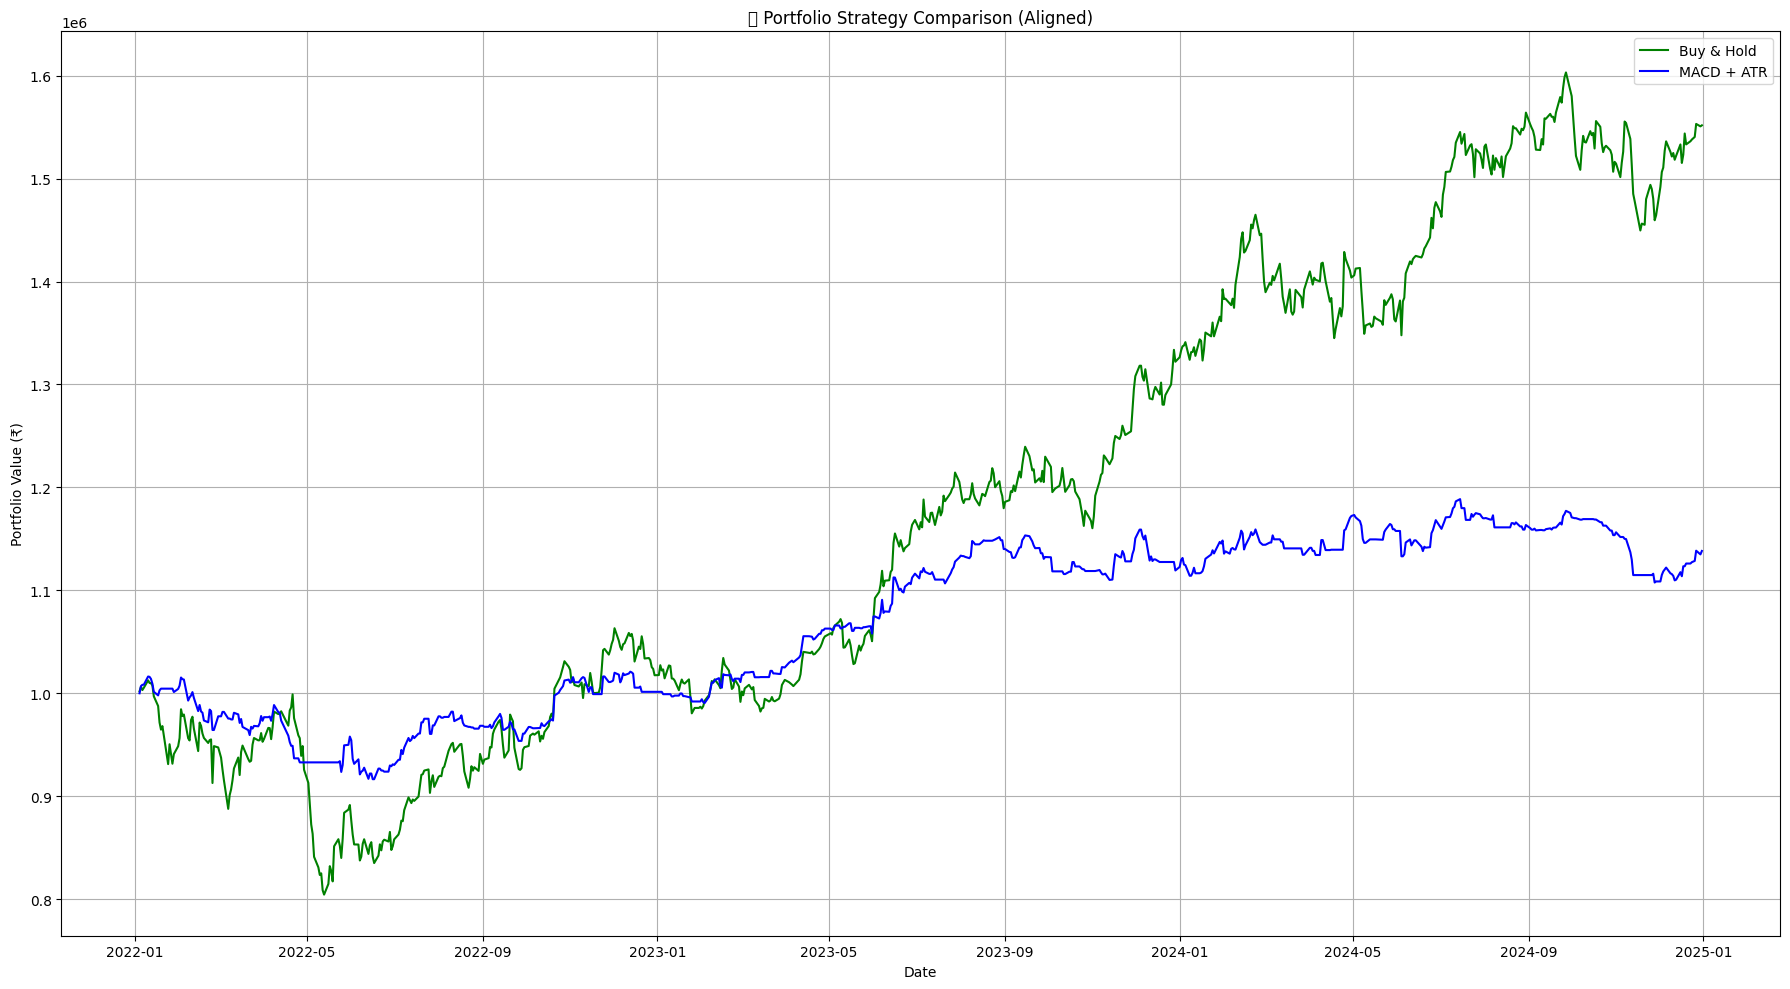

In [28]:
# Rename and align both strategies
buy_hold_value = portfolio_value.rename('Buy & Hold')
macd_atr_value = combined_cum_returns.rename('MACD + ATR')

# Align the two series strictly on overlapping dates only
comparison_df = pd.concat([buy_hold_value, macd_atr_value], axis=1).dropna()

# Replot with aligned data
plt.figure(figsize=(18, 10))
plt.plot(comparison_df.index, comparison_df['Buy & Hold'], label='Buy & Hold', color='green')
plt.plot(comparison_df.index, comparison_df['MACD + ATR'], label='MACD + ATR', color='blue')
plt.title('📊 Portfolio Strategy Comparison (Aligned)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
print("🔁 Strategy Comparison Summary:")
print(f"{'Metric':<25}{'Buy & Hold':<20}{'MACD + ATR':<20}")
print("-" * 65)
print(f"{'Final Value (₹)':<25}{buy_hold_value.iloc[-1]:<20,.2f}{macd_atr_value.iloc[-1]:<20,.2f}")
print(f"{'Total Return':<25}{(buy_hold_value.iloc[-1]/initial_investment - 1):<20.2%}{(macd_atr_value.iloc[-1]/initial_investment - 1):<20.2%}")


🔁 Strategy Comparison Summary:
Metric                   Buy & Hold          MACD + ATR          
-----------------------------------------------------------------
Final Value (₹)          1,551,722.76        1,138,243.43        
Total Return             55.17%              13.82%              


In [30]:
print("🗓 Date Range Used for Comparison:", comparison_df.index.min().date(), "to", comparison_df.index.max().date())


🗓 Date Range Used for Comparison: 2022-01-04 to 2024-12-31
